# Recommender System for Neighbourhoods

### Leonardo Ramirez 
### March 2021


### Peer-graded assignment for final module "Applied Data Science Capstone" part of Coursera "IBM Data Science Professional Certificate"

## Table of contents:
* [Data](#data)
    - [London Neighbourhoods](#lon_data)
        - [Collection](#lon_coll)
        - [Cleaning](#lon_clean)
    - [London Postcodes](#post_data)
        - [Manipulation](#adding_coor)
    - [FOURSQUARE Venues](#venues)
* [Data Exploration and Manipulation](#mani)
    - [Preliminary Exploration](#explo)
    - [Clustering](#Clust)
* [Recommender system](#rec)


First we import all the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
#pip install requests beautifulsoup4

## Data <a name="data"></a>
As discussed in the report and presentationt there are three sources of data, namely:
- A list of London Neighbourhoods (outward code from postcode) coming from Wikipedia
- A list of coordinates for each London Neightbourhood 
- A list of venues for each London Neighbourhood from FOURSQUARES

### London Neighbourhoods <a name="lon_data"></a>
London contains 8 different area postcodes, each of which contains several districts. Both the Area Code and the District together define what is called the Outward code. We use this outward code to define Neighbourhoods.

#### Collection <a name="lon_data"></a>

In [3]:
#input
url_E  = 'https://en.wikipedia.org/wiki/E_postcode_area'
url_EC = 'https://en.wikipedia.org/wiki/EC_postcode_area'
url_N  = 'https://en.wikipedia.org/wiki/N_postcode_area'
url_NW = 'https://en.wikipedia.org/wiki/NW_postcode_area'
url_SE = 'https://en.wikipedia.org/wiki/SE_postcode_area'
url_SW = 'https://en.wikipedia.org/wiki/SW_postcode_area'
url_W  = 'https://en.wikipedia.org/wiki/W_postcode_area'
url_WC = 'https://en.wikipedia.org/wiki/WC_postcode_area'


E_postcode_df  = pd.read_html(url_E)
EC_postcode_df = pd.read_html(url_EC)
N_postcode_df  = pd.read_html(url_N)
NW_postcode_df = pd.read_html(url_NW)
SE_postcode_df = pd.read_html(url_SE)
SW_postcode_df = pd.read_html(url_SW)
W_postcode_df  = pd.read_html(url_W)
WC_postcode_df = pd.read_html(url_WC)


#### Cleaning <a name="lon_clean"></a>
There are several several steps in the data cleaning process.

The above post_code dataframes are list and generally the second element contains the table of postcodes and neighbourhoods so the **first step** in general is to reassigned the postcode dataframe to the postcode table.

The **second step** generally is removing non-geographic postcodes.

The **third step** is generally removing unnecessary details in the coverage column. The Coverage column will generally contain the Neighbourhood followed by information about it. We remove anything after "district:". 

Some postcode districts known as head districts (eg SW1?) will not a neighbourhood in their Coverage column so domenain knowledge is used to fill this information. This is generally the **fourth step**.

This is repeated for every single area code.

Finally we rename all the columns in the main London_df dataframe.

In [4]:
#reassign postcode dataframe to the postcode table
E_postcode_df = E_postcode_df[1] 

In [5]:
#inspect dataframe
E_postcode_df.head()

Postcode district Post town  \
0                E1    LONDON   
1               E1W    LONDON   
2                E2    LONDON   
3                E3    LONDON   
4                E4    LONDON   

                                            Coverage  \
0  Eastern head district: Aldgate (part), Bishops...   
1  Wapping, St Katharine Docks, Stepney (part), S...   
2  Bethnal Green district: Bethnal Green, Haggers...   
3  Bow district: Bow, Bow Common, Bromley-by-Bow,...   
4  Chingford district: Chingford, Sewardstone, Hi...   

                          Local authority area(s)  
0          Tower Hamlets, Hackney, City of London  
1                                   Tower Hamlets  
2                          Tower Hamlets, Hackney  
3                           Tower Hamlets, Newham  
4  Waltham Forest, Enfield, Epping Forest (Essex)

In [6]:
#remove non-geographic postcodes
E_postcode_df = E_postcode_df[~E_postcode_df['Coverage'].str.contains('Non-geographic')]

In [7]:
#remove everything after the district or neighbourhood
E_postcode_df['Coverage'] = E_postcode_df['Coverage'].str.rpartition(' district:')[0]

In [8]:
#manually update Coverage /neighbourh using doman knowledge
E_postcode_df['Coverage'][0:2] = ['Algate', 'Wapping']

In [9]:
#check postcode dataframe
E_postcode_df

Postcode district Post town                           Coverage  \
0                 E1    LONDON                             Algate   
1                E1W    LONDON                            Wapping   
2                 E2    LONDON                      Bethnal Green   
3                 E3    LONDON                                Bow   
4                 E4    LONDON                          Chingford   
5                 E5    LONDON                            Clapton   
6                 E6    LONDON                           East Ham   
7                 E7    LONDON                        Forest Gate   
8                 E8    LONDON                            Hackney   
9                 E9    LONDON                           Homerton   
10               E10    LONDON                             Leyton   
11               E11    LONDON                        Leytonstone   
12               E12    LONDON                         Manor Park   
13               E13    LONDON                           Plaistow   
14               E14    LONDON                             Poplar   
15               E15    LONDON                          Stratford   
16               E16    LONDON  Victoria Docks and North Woolwich   
17               E17    LONDON                        Walthamstow   
18               E18    LONDON        Woodford and South Woodford   
19               E20    LONDON                       Olympic Park   

                           Local authority area(s)  
0           Tower Hamlets, Hackney, City of London  
1                                    Tower Hamlets  
2                           Tower Hamlets, Hackney  
3                            Tower Hamlets, Newham  
4   Waltham Forest, Enfield, Epping Forest (Essex)  
5                          Hackney, Waltham Forest  
6                     Newham, Barking and Dagenham  
7                           Newham, Waltham Forest  
8                                          Hackney  
9                           Hackney, Tower Hamlets  
10                         Waltham Forest, Hackney  
11                       Waltham Forest, Redbridge  
12                               Newham, Redbridge  
13                                          Newham  
14                                   Tower Hamlets  
15  Newham, Waltham Forest, Hackney, Tower Hamlets  
16                                          Newham  
17                                  Waltham Forest  
18                                       Redbridge  
19  Newham, Waltham Forest, Hackney, Tower Hamlets

In [10]:
#reassign postcode dataframe to the postcode table
EC_postcode_df = EC_postcode_df[2]

In [11]:
#remove non-geographic postcodes
EC_postcode_df = EC_postcode_df[~EC_postcode_df['Local authority area(s)'].str.contains('non-geographic')]

In [12]:
#check postcode dataframe
EC_postcode_df

Postcode district Post town                                      Coverage  \
0               EC1A    LONDON                     St Bartholomew's Hospital   
1               EC1M    LONDON                       Clerkenwell, Farringdon   
2               EC1N    LONDON                                 Hatton Garden   
4               EC1R    LONDON              Finsbury, Finsbury Estate (west)   
5               EC1V    LONDON      Finsbury (east), Moorfields Eye Hospital   
6               EC1Y    LONDON                     St Luke's, Bunhill Fields   
7               EC2A    LONDON                                    Shoreditch   
8               EC2M    LONDON                   Broadgate, Liverpool Street   
9               EC2N    LONDON                    Old Broad Street, Tower 42   
11              EC2R    LONDON                               Bank of England   
12              EC2V    LONDON                                     Guildhall   
13              EC2Y    LONDON                                      Barbican   
14              EC3A    LONDON                          St Mary Axe, Aldgate   
15              EC3M    LONDON           Lloyd's of London, Fenchurch Street   
16              EC3N    LONDON                   Tower Hill, Tower of London   
18              EC3R    LONDON                        Monument, Billingsgate   
19              EC3V    LONDON  Cornhill, Gracechurch Street, Lombard Street   
20              EC4A    LONDON                                   Fetter Lane   
21              EC4M    LONDON                                     St Paul's   
22              EC4N    LONDON                                 Mansion House   
24              EC4R    LONDON                                 Cannon Street   
25              EC4V    LONDON                                   Blackfriars   
26              EC4Y    LONDON                                        Temple   

               Local authority area(s)  
0            City of London, Islington  
1    Islington, Camden, City of London  
2               Camden, City of London  
4                    Islington, Camden  
5                   Islington, Hackney  
6            Islington, City of London  
7   Islington, Hackney, City of London  
8        City of London, Tower Hamlets  
9                       City of London  
11                      City of London  
12                      City of London  
13                      City of London  
14                      City of London  
15                      City of London  
16       Tower Hamlets, City of London  
18                      City of London  
19                      City of London  
20         City of London, Westminster  
21                      City of London  
22                      City of London  
24                      City of London  
25                      City of London  
26         City of London, Westminster

In [13]:
#reassign postcode dataframe to the postcode table
N_postcode_df = N_postcode_df[1]

In [14]:
#remove non-geographic postcodes
N_postcode_df = N_postcode_df[~N_postcode_df['Local authority area(s)'].str.contains('non-geographic')]

In [15]:
#inspect dataframe
N_postcode_df.head()

Postcode district Post town  \
0                N1    LONDON   
1               N1C    LONDON   
3                N2    LONDON   
4                N3    LONDON   
5                N4    LONDON   

                                            Coverage  \
0  Northern head district: Barnsbury (part), Cano...   
1                                Kings Cross Central   
3  East Finchley district: East Finchley, Fortis ...   
4  Finchley district: Finchley, Church End, Finch...   
5  Finsbury Park district: Finsbury Park, Manor H...   

        Local authority area(s)  
0    Hackney, Islington, Camden  
1                        Camden  
3              Barnet, Haringey  
4                        Barnet  
5  Haringey, Islington, Hackney

In [16]:
#remove everything after the district or neighbourhood
N_postcode_df['Coverage'] = N_postcode_df['Coverage'].str.rpartition(' district:')[0]

In [17]:
#manually update Coverage /neighbourh using doman knowledge
N_postcode_df['Coverage'][0:2] = ['Islington','Kings Cross Central']

In [18]:
#check postcode dataframe
N_postcode_df

Postcode district Post town             Coverage  \
0                 N1    LONDON            Islington   
1                N1C    LONDON  Kings Cross Central   
3                 N2    LONDON        East Finchley   
4                 N3    LONDON             Finchley   
5                 N4    LONDON        Finsbury Park   
6                 N5    LONDON             Highbury   
7                 N6    LONDON             Highgate   
8                 N7    LONDON             Holloway   
9                 N8    LONDON              Hornsey   
10                N9    LONDON       Lower Edmonton   
11               N10    LONDON         Muswell Hill   
12               N11    LONDON        New Southgate   
13               N12    LONDON       North Finchley   
14               N13    LONDON        Palmers Green   
15               N14    LONDON            Southgate   
16               N15    LONDON      South Tottenham   
17               N16    LONDON      Stoke Newington   
18               N17    LONDON            Tottenham   
19               N18    LONDON       Upper Edmonton   
20               N19    LONDON       Upper Holloway   
21               N20    LONDON            Whetstone   
22               N21    LONDON       Winchmore Hill   
23               N22    LONDON           Wood Green   

         Local authority area(s)  
0     Hackney, Islington, Camden  
1                         Camden  
3               Barnet, Haringey  
4                         Barnet  
5   Haringey, Islington, Hackney  
6             Islington, Hackney  
7    Camden, Haringey, Islington  
8              Islington, Camden  
9            Haringey, Islington  
10                       Enfield  
11              Haringey, Barnet  
12     Enfield, Barnet, Haringey  
13                        Barnet  
14                       Enfield  
15               Enfield, Barnet  
16                      Haringey  
17            Islington, Hackney  
18                      Haringey  
19                       Enfield  
20             Islington, Camden  
21                        Barnet  
22                       Enfield  
23             Haringey, Enfield

In [19]:
#reassign postcode dataframe to the postcode table
NW_postcode_df = NW_postcode_df[1]

In [20]:
#remove non-geographic postcodes
NW_postcode_df = NW_postcode_df[~NW_postcode_df['Local authority area(s)'].str.contains('non-geographic')]

In [21]:
#inspect dataframe
NW_postcode_df.head()

Postcode district Post town  \
0               NW1    LONDON   
2               NW2    LONDON   
3               NW3    LONDON   
4               NW4    LONDON   
5               NW5    LONDON   

                                            Coverage Local authority area(s)  
0  North Western head district: Marylebone (part)...     Camden, Westminster  
2  Cricklewood district: Cricklewood, Dollis Hill...   Barnet, Brent, Camden  
3  Hampstead district: Hampstead, Belsize Park, F...          Camden, Barnet  
4        Hendon district: Hendon, Brent Cross (part)                  Barnet  
5  Kentish Town district: Kentish Town, Camden To...       Camden, Islington

In [22]:
#remove everything after the district or neighbourhood
NW_postcode_df['Coverage'] = NW_postcode_df['Coverage'].str.rpartition(' district:')[0]

In [23]:
#manually update Coverage /neighbourh using doman knowledge
NW_postcode_df['Coverage'][0:1] = ['Regents Park']

In [24]:
#check postcode dataframe
NW_postcode_df

Postcode district Post town        Coverage  \
0                NW1    LONDON    Regents Park   
2                NW2    LONDON     Cricklewood   
3                NW3    LONDON       Hampstead   
4                NW4    LONDON          Hendon   
5                NW5    LONDON    Kentish Town   
6                NW6    LONDON         Kilburn   
7                NW7    LONDON       Mill Hill   
8                NW8    LONDON  St John's Wood   
9                NW9    LONDON        The Hyde   
10              NW10    LONDON       Willesden   
11              NW11    LONDON   Golders Green   

                              Local authority area(s)  
0                                 Camden, Westminster  
2                               Barnet, Brent, Camden  
3                                      Camden, Barnet  
4                                              Barnet  
5                                   Camden, Islington  
6                          Brent, Camden, Westminster  
7                                              Barnet  
8                                 Westminster, Camden  
9                               Barnet, Brent, Harrow  
10  Brent, Ealing, Hammersmith and Fulham, Kensing...  
11                                             Barnet

In [25]:
#reassign postcode dataframe to the postcode table
SE_postcode_df = SE_postcode_df[1]

In [26]:
#remove non-geographic postcodes
SE_postcode_df = SE_postcode_df[~SE_postcode_df['Local authority area(s)'].str.contains('non-geographic')]

In [27]:
#inspect dataframe
SE_postcode_df.head()

Postcode district Post town  \
0               SE1    LONDON   
2               SE2    LONDON   
3               SE3    LONDON   
4               SE4    LONDON   
5               SE5    LONDON   

                                            Coverage Local authority area(s)  
0  South Eastern head district: Bankside, South B...      Lambeth, Southwark  
2  Abbey Wood district: Abbey Wood, West Heath, C...       Bexley, Greenwich  
3  Blackheath district: Blackheath, Kidbrooke, We...     Greenwich, Lewisham  
4  Brockley district: Brockley, Crofton Park, Lad...                Lewisham  
5  Camberwell district: Camberwell, Denmark Hill,...      Southwark, Lambeth

In [28]:
#remove everything after the district or neighbourhood
SE_postcode_df['Coverage'] = SE_postcode_df['Coverage'].str.rpartition(' district:')[0]

In [29]:
#manually update Coverage /neighbourh using doman knowledge
SE_postcode_df['Coverage'][0:1] = ['South Bank']

In [30]:
#check postcode dataframe
SE_postcode_df

Postcode district Post town       Coverage  \
0                SE1    LONDON     South Bank   
2                SE2    LONDON     Abbey Wood   
3                SE3    LONDON     Blackheath   
4                SE4    LONDON       Brockley   
5                SE5    LONDON     Camberwell   
6                SE6    LONDON        Catford   
7                SE7    LONDON       Charlton   
8                SE8    LONDON       Deptford   
9                SE9    LONDON         Eltham   
10              SE10    LONDON      Greenwich   
11              SE11    LONDON     Kennington   
12              SE12    LONDON            Lee   
13              SE13    LONDON       Lewisham   
14              SE14    LONDON      New Cross   
15              SE15    LONDON        Peckham   
16              SE16    LONDON    Rotherhithe   
17              SE17    LONDON       Walworth   
18              SE18    LONDON       Woolwich   
19              SE19    LONDON        Norwood   
20              SE20    LONDON        Anerley   
21              SE21    LONDON        Dulwich   
22              SE22    LONDON   East Dulwich   
23              SE23    LONDON    Forest Hill   
24              SE24    LONDON     Herne Hill   
25              SE25    LONDON  South Norwood   
26              SE26    LONDON       Sydenham   
27              SE27    LONDON   West Norwood   
28              SE28    LONDON     Thamesmead   

                           Local authority area(s)  
0                               Lambeth, Southwark  
2                                Bexley, Greenwich  
3                              Greenwich, Lewisham  
4                                         Lewisham  
5                               Southwark, Lambeth  
6                                         Lewisham  
7                                        Greenwich  
8                   Greenwich, Lewisham, Southwark  
9             Bexley, Bromley, Greenwich, Lewisham  
10                             Greenwich, Lewisham  
11                              Lambeth, Southwark  
12                    Greenwich, Lewisham, Bromley  
13                             Greenwich, Lewisham  
14                                        Lewisham  
15                             Lewisham, Southwark  
16                             Lewisham, Southwark  
17                                       Southwark  
18                               Bexley, Greenwich  
19  Bromley, Croydon, Lambeth, Lewisham, Southwark  
20                                         Bromley  
21                              Lambeth, Southwark  
22                                       Southwark  
23                             Lewisham, Southwark  
24                              Lambeth, Southwark  
25                                         Croydon  
26                    Bromley, Lewisham, Southwark  
27                                         Lambeth  
28                               Bexley, Greenwich

In [31]:
#reassign postcode dataframe to the postcode table
SW_postcode_df = SW_postcode_df[1]

In [32]:
#remove everything after the district or neighbourhood
SW_postcode_df['Coverage'] = SW_postcode_df['Coverage'].str.rpartition(' district:')[0]

In [33]:
#inspect dataframe
SW_postcode_df

Postcode district Post town          Coverage  \
0               SW1A    LONDON                     
1               SW1E    LONDON                     
2               SW1H    LONDON                     
3               SW1P    LONDON                     
4               SW1V    LONDON                     
5               SW1W    LONDON                     
6               SW1X    LONDON                     
7               SW1Y    LONDON                     
8                SW2    LONDON           Brixton   
9                SW3    LONDON           Chelsea   
10               SW4    LONDON           Clapham   
11               SW5    LONDON       Earls Court   
12               SW6    LONDON            Fulham   
13               SW7    LONDON  South Kensington   
14               SW8    LONDON     South Lambeth   
15               SW9    LONDON         Stockwell   
16              SW10    LONDON     West Brompton   
17              SW11    LONDON    Battersea head   
18              SW12    LONDON            Balham   
19              SW13    LONDON            Barnes   
20              SW14    LONDON          Mortlake   
21              SW15    LONDON            Putney   
22              SW16    LONDON         Streatham   
23              SW17    LONDON           Tooting   
24              SW18    LONDON        Wandsworth   
25              SW19    LONDON         Wimbledon   
26              SW20    LONDON    West Wimbledon   

                              Local authority area(s)  
0                                         Westminster  
1                                         Westminster  
2                                         Westminster  
3                                         Westminster  
4                                         Westminster  
5                 Westminster, Kensington and Chelsea  
6                 Westminster, Kensington and Chelsea  
7                                         Westminster  
8                                             Lambeth  
9                              Kensington and Chelsea  
10                                Lambeth, Wandsworth  
11                             Kensington and Chelsea  
12                             Hammersmith and Fulham  
13                Kensington and Chelsea, Westminster  
14                                Lambeth, Wandsworth  
15                                            Lambeth  
16     Kensington and Chelsea, Hammersmith and Fulham  
17                                Wandsworth, Lambeth  
18                                Wandsworth, Lambeth  
19                               Richmond upon Thames  
20                               Richmond upon Thames  
21  Wandsworth, Kingston upon Thames, Richmond upo...  
22               Lambeth, Croydon, Wandsworth, Merton  
23                                 Wandsworth, Merton  
24                                         Wandsworth  
25                                 Merton, Wandsworth  
26                                             Merton

In [34]:
#manually update Coverage /neighbourh using doman knowledge
SW_postcode_df['Coverage'][0:8] =['Government and Official','Northern Victoria',
                                  'St James Park', 'Pimlico', 'Victoria', 
                                  'Lower Belgravia', 'Belgravia', 'St James']

In [35]:
#check postcode dataframe
SW_postcode_df

Postcode district Post town                 Coverage  \
0               SW1A    LONDON  Government and Official   
1               SW1E    LONDON        Northern Victoria   
2               SW1H    LONDON            St James Park   
3               SW1P    LONDON                  Pimlico   
4               SW1V    LONDON                 Victoria   
5               SW1W    LONDON          Lower Belgravia   
6               SW1X    LONDON                Belgravia   
7               SW1Y    LONDON                 St James   
8                SW2    LONDON                  Brixton   
9                SW3    LONDON                  Chelsea   
10               SW4    LONDON                  Clapham   
11               SW5    LONDON              Earls Court   
12               SW6    LONDON                   Fulham   
13               SW7    LONDON         South Kensington   
14               SW8    LONDON            South Lambeth   
15               SW9    LONDON                Stockwell   
16              SW10    LONDON            West Brompton   
17              SW11    LONDON           Battersea head   
18              SW12    LONDON                   Balham   
19              SW13    LONDON                   Barnes   
20              SW14    LONDON                 Mortlake   
21              SW15    LONDON                   Putney   
22              SW16    LONDON                Streatham   
23              SW17    LONDON                  Tooting   
24              SW18    LONDON               Wandsworth   
25              SW19    LONDON                Wimbledon   
26              SW20    LONDON           West Wimbledon   

                              Local authority area(s)  
0                                         Westminster  
1                                         Westminster  
2                                         Westminster  
3                                         Westminster  
4                                         Westminster  
5                 Westminster, Kensington and Chelsea  
6                 Westminster, Kensington and Chelsea  
7                                         Westminster  
8                                             Lambeth  
9                              Kensington and Chelsea  
10                                Lambeth, Wandsworth  
11                             Kensington and Chelsea  
12                             Hammersmith and Fulham  
13                Kensington and Chelsea, Westminster  
14                                Lambeth, Wandsworth  
15                                            Lambeth  
16     Kensington and Chelsea, Hammersmith and Fulham  
17                                Wandsworth, Lambeth  
18                                Wandsworth, Lambeth  
19                               Richmond upon Thames  
20                               Richmond upon Thames  
21  Wandsworth, Kingston upon Thames, Richmond upo...  
22               Lambeth, Croydon, Wandsworth, Merton  
23                                 Wandsworth, Merton  
24                                         Wandsworth  
25                                 Merton, Wandsworth  
26                                             Merton

In [36]:
#reassign postcode dataframe to the postcode table
W_postcode_df = W_postcode_df[1]

In [37]:
#remove non-geographic postcodes
W_postcode_df[~W_postcode_df['Local authority area(s)'].str.contains('non-geographic')]

Postcode district Post town  \
1                W1B    LONDON   
2                W1C    LONDON   
3                W1D    LONDON   
4                W1F    LONDON   
5                W1G    LONDON   
6                W1H    LONDON   
7                W1J    LONDON   
8                W1K    LONDON   
9                W1S    LONDON   
10               W1T    LONDON   
11               W1U    LONDON   
12               W1W    LONDON   
13                W2    LONDON   
14                W3    LONDON   
15                W4    LONDON   
16                W5    LONDON   
17                W6    LONDON   
18                W7    LONDON   
19                W8    LONDON   
20                W9    LONDON   
21               W10    LONDON   
22               W11    LONDON   
23               W12    LONDON   
24               W13    LONDON   
25               W14    LONDON   

                                             Coverage  \
1                       Portland Place, Regent Street   
2                                Oxford Street (west)   
3           Soho (south east); Chinatown, Soho Square   
4                                   Soho (north west)   
5                                       Harley Street   
6                                          Marylebone   
7                         Mayfair (south), Piccadilly   
8                   Mayfair (north), Grosvenor Square   
9   Mayfair (east), Hanover Square, Savile Row, Ro...   
10                    Fitzrovia, Tottenham Court Road   
11                                         Marylebone   
12                   Great Portland Street, Fitzrovia   
13  Paddington head district: Paddington, Bayswate...   
14  Acton district: Acton, West Acton, North Acton...   
15  Chiswick district: Chiswick, Gunnersbury, Turn...   
16  Ealing district: Ealing, South Ealing, Ealing ...   
17  Hammersmith district: Fulham, Hammersmith, Rav...   
18     Hanwell district: Hanwell, Boston Manor (part)   
19  Kensington district: Kensington, Holland Park ...   
20  Maida Hill district: Maida Hill, Maida Vale, L...   
21  North Kensington district: North Kensington, K...   
22  Notting Hill district: Notting Hill, Ladbroke ...   
23  Shepherds Bush district: Shepherd's Bush, Whit...   
24  West Ealing district: West Ealing, Northfields...   
25  West Kensington district: West Kensington, Ken...   

                              Local authority area(s)  
1                                         Westminster  
2                                         Westminster  
3                                         Westminster  
4                                         Westminster  
5                                         Westminster  
6                                         Westminster  
7                                         Westminster  
8                                         Westminster  
9                                         Westminster  
10                                             Camden  
11                                        Westminster  
12                                        Westminster  
13                Westminster, Kensington and Chelsea  
14           Ealing, Hounslow, Hammersmith and Fulham  
15           Hounslow, Ealing, Hammersmith and Fulham  
16                                             Ealing  
17                   Hammersmith and Fulham, Hounslow  
18                                             Ealing  
19                             Kensington and Chelsea  
20                         Westminster, Brent, Camden  
21  Kensington and Chelsea, Westminster, Hammersmi...  
22  Kensington and Chelsea, Westminster, Hammersmi...  
23                             Hammersmith and Fulham  
24                                             Ealing  
25     Hammersmith and Fulham, Kensington and Chelsea

In [38]:
#remove everything after the district or neighbourhood
W_postcode_df['Coverage'][13:] = W_postcode_df['Coverage'][13:].str.rpartition(' district:')[0]

In [39]:
W_postcode_df['Coverage'][6] = 'Marylebone (west)'

In [40]:
#check postcode dataframe
W_postcode_df

Postcode district Post town  \
0                W1A    LONDON   
1                W1B    LONDON   
2                W1C    LONDON   
3                W1D    LONDON   
4                W1F    LONDON   
5                W1G    LONDON   
6                W1H    LONDON   
7                W1J    LONDON   
8                W1K    LONDON   
9                W1S    LONDON   
10               W1T    LONDON   
11               W1U    LONDON   
12               W1W    LONDON   
13                W2    LONDON   
14                W3    LONDON   
15                W4    LONDON   
16                W5    LONDON   
17                W6    LONDON   
18                W7    LONDON   
19                W8    LONDON   
20                W9    LONDON   
21               W10    LONDON   
22               W11    LONDON   
23               W12    LONDON   
24               W13    LONDON   
25               W14    LONDON   

                                             Coverage  \
0                    PO boxes & Admail codes in W1[7]   
1                       Portland Place, Regent Street   
2                                Oxford Street (west)   
3           Soho (south east); Chinatown, Soho Square   
4                                   Soho (north west)   
5                                       Harley Street   
6                                   Marylebone (west)   
7                         Mayfair (south), Piccadilly   
8                   Mayfair (north), Grosvenor Square   
9   Mayfair (east), Hanover Square, Savile Row, Ro...   
10                    Fitzrovia, Tottenham Court Road   
11                                         Marylebone   
12                   Great Portland Street, Fitzrovia   
13                                    Paddington head   
14                                              Acton   
15                                           Chiswick   
16                                             Ealing   
17                                        Hammersmith   
18                                            Hanwell   
19                                         Kensington   
20                                         Maida Hill   
21                                   North Kensington   
22                                       Notting Hill   
23                                     Shepherds Bush   
24                                        West Ealing   
25                                    West Kensington   

                              Local authority area(s)  
0                                      non-geographic  
1                                         Westminster  
2                                         Westminster  
3                                         Westminster  
4                                         Westminster  
5                                         Westminster  
6                                         Westminster  
7                                         Westminster  
8                                         Westminster  
9                                         Westminster  
10                                             Camden  
11                                        Westminster  
12                                        Westminster  
13                Westminster, Kensington and Chelsea  
14           Ealing, Hounslow, Hammersmith and Fulham  
15           Hounslow, Ealing, Hammersmith and Fulham  
16                                             Ealing  
17                   Hammersmith and Fulham, Hounslow  
18                                             Ealing  
19                             Kensington and Chelsea  
20                         Westminster, Brent, Camden  
21  Kensington and Chelsea, Westminster, Hammersmi...  
22  Kensington and Chelsea, Westminster, Hammersmi...  
23                             Hammersmith and Fulham  
24                                             Ealing  
25     Hammersmith and Fulham, Kensington and Chelsea

In [41]:
#reassign postcode dataframe to the postcode table
WC_postcode_df = WC_postcode_df[1]

In [42]:
WC_postcode_df

Postcode district Post town  \
0               WC1A    LONDON   
1               WC1B    LONDON   
2               WC1E    LONDON   
3               WC1H    LONDON   
4               WC1N    LONDON   
5               WC1R    LONDON   
6               WC1V    LONDON   
7               WC1X    LONDON   
8               WC2A    LONDON   
9               WC2B    LONDON   
10              WC2E    LONDON   
11              WC2H    LONDON   
12              WC2N    LONDON   
13              WC2R    LONDON   

                                             Coverage  \
0                                   New Oxford Street   
1         Bloomsbury, British Museum, Southampton Row   
2                     University College London, SOAS   
3              St Pancras, UCL Institute of Education   
4                 Russell Square, Great Ormond Street   
5                                          Gray's Inn   
6                                        High Holborn   
7   Kings Cross, Finsbury (west), Clerkenwell (north)   
8   Lincoln's Inn Fields, Royal Courts of Justice,...   
9                       Drury Lane, Kingsway, Aldwych   
10                                      Covent Garden   
11                        Leicester Square, St. Giles   
12                                      Charing Cross   
13                      Somerset House, Temple (west)   

                Local authority area(s)  
0                                Camden  
1                                Camden  
2                                Camden  
3                                Camden  
4                                Camden  
5                                Camden  
6                Camden, City of London  
7                     Camden, Islington  
8   Camden, Westminster, City of London  
9                   Camden, Westminster  
10                          Westminster  
11                  Camden, Westminster  
12                          Westminster  
13                          Westminster

In [43]:
London_df = pd.concat([E_postcode_df, 
                       EC_postcode_df,
                       N_postcode_df,
                       NW_postcode_df,
                       SE_postcode_df,
                       SW_postcode_df,
                       W_postcode_df,
                       WC_postcode_df], ignore_index=True)
London_df.head()

Postcode district Post town       Coverage  \
0                E1    LONDON         Algate   
1               E1W    LONDON        Wapping   
2                E2    LONDON  Bethnal Green   
3                E3    LONDON            Bow   
4                E4    LONDON      Chingford   

                          Local authority area(s)  
0          Tower Hamlets, Hackney, City of London  
1                                   Tower Hamlets  
2                          Tower Hamlets, Hackney  
3                           Tower Hamlets, Newham  
4  Waltham Forest, Enfield, Epping Forest (Essex)

In [44]:
London_df.set_index('Postcode district')

Post town  \
Postcode district             
E1                   LONDON   
E1W                  LONDON   
E2                   LONDON   
E3                   LONDON   
E4                   LONDON   
E5                   LONDON   
E6                   LONDON   
E7                   LONDON   
E8                   LONDON   
E9                   LONDON   
E10                  LONDON   
E11                  LONDON   
E12                  LONDON   
E13                  LONDON   
E14                  LONDON   
E15                  LONDON   
E16                  LONDON   
E17                  LONDON   
E18                  LONDON   
E20                  LONDON   
EC1A                 LONDON   
EC1M                 LONDON   
EC1N                 LONDON   
EC1R                 LONDON   
EC1V                 LONDON   
EC1Y                 LONDON   
EC2A                 LONDON   
EC2M                 LONDON   
EC2N                 LONDON   
EC2R                 LONDON   
EC2V                 LONDON   
EC2Y                 LONDON   
EC3A                 LONDON   
EC3M                 LONDON   
EC3N                 LONDON   
EC3R                 LONDON   
EC3V                 LONDON   
EC4A                 LONDON   
EC4M                 LONDON   
EC4N                 LONDON   
EC4R                 LONDON   
EC4V                 LONDON   
EC4Y                 LONDON   
N1                   LONDON   
N1C                  LONDON   
N2                   LONDON   
N3                   LONDON   
N4                   LONDON   
N5                   LONDON   
N6                   LONDON   
N7                   LONDON   
N8                   LONDON   
N9                   LONDON   
N10                  LONDON   
N11                  LONDON   
N12                  LONDON   
N13                  LONDON   
N14                  LONDON   
N15                  LONDON   
N16                  LONDON   
N17                  LONDON   
N18                  LONDON   
N19                  LONDON   
N20                  LONDON   
N21                  LONDON   
N22                  LONDON   
NW1                  LONDON   
NW2                  LONDON   
NW3                  LONDON   
NW4                  LONDON   
NW5                  LONDON   
NW6                  LONDON   
NW7                  LONDON   
NW8                  LONDON   
NW9                  LONDON   
NW10                 LONDON   
NW11                 LONDON   
SE1                  LONDON   
SE2                  LONDON   
SE3                  LONDON   
SE4                  LONDON   
SE5                  LONDON   
SE6                  LONDON   
SE7                  LONDON   
SE8                  LONDON   
SE9                  LONDON   
SE10                 LONDON   
SE11                 LONDON   
SE12                 LONDON   
SE13                 LONDON   
SE14                 LONDON   
SE15                 LONDON   
SE16                 LONDON   
SE17                 LONDON   
SE18                 LONDON   
SE19                 LONDON   
SE20                 LONDON   
SE21                 LONDON   
SE22                 LONDON   
SE23                 LONDON   
SE24                 LONDON   
SE25                 LONDON   
SE26                 LONDON   
SE27                 LONDON   
SE28                 LONDON   
SW1A                 LONDON   
SW1E                 LONDON   
SW1H                 LONDON   
SW1P                 LONDON   
SW1V                 LONDON   
SW1W                 LONDON   
SW1X                 LONDON   
SW1Y                 LONDON   
SW2                  LONDON   
SW3                  LONDON   
SW4                  LONDON   
SW5                  LONDON   
SW6                  LONDON   
SW7                  LONDON   
SW8                  LONDON   
SW9                  LONDON   
SW10                 LONDON   
SW11                 LONDON   
SW12                 LONDON   
SW13                 LONDON   
SW14                 LONDON   
SW15                 LONDON   
SW16               

In [45]:
#rename columns
London_df.rename(columns = {'Postcode district': 'Postcode',
                           'Post town': 'City',
                           'Coverage': 'Neighbourhood',
                           'Local authority area(s)': 'Borough'}, inplace=True)

In [46]:
London_df

Postcode    City                                      Neighbourhood  \
0         E1  LONDON                                             Algate   
1        E1W  LONDON                                            Wapping   
2         E2  LONDON                                      Bethnal Green   
3         E3  LONDON                                                Bow   
4         E4  LONDON                                          Chingford   
5         E5  LONDON                                            Clapton   
6         E6  LONDON                                           East Ham   
7         E7  LONDON                                        Forest Gate   
8         E8  LONDON                                            Hackney   
9         E9  LONDON                                           Homerton   
10       E10  LONDON                                             Leyton   
11       E11  LONDON                                        Leytonstone   
12       E12  LONDON                                         Manor Park   
13       E13  LONDON                                           Plaistow   
14       E14  LONDON                                             Poplar   
15       E15  LONDON                                          Stratford   
16       E16  LONDON                  Victoria Docks and North Woolwich   
17       E17  LONDON                                        Walthamstow   
18       E18  LONDON                        Woodford and South Woodford   
19       E20  LONDON                                       Olympic Park   
20      EC1A  LONDON                          St Bartholomew's Hospital   
21      EC1M  LONDON                            Clerkenwell, Farringdon   
22      EC1N  LONDON                                      Hatton Garden   
23      EC1R  LONDON                   Finsbury, Finsbury Estate (west)   
24      EC1V  LONDON           Finsbury (east), Moorfields Eye Hospital   
25      EC1Y  LONDON                          St Luke's, Bunhill Fields   
26      EC2A  LONDON                                         Shoreditch   
27      EC2M  LONDON                        Broadgate, Liverpool Street   
28      EC2N  LONDON                         Old Broad Street, Tower 42   
29      EC2R  LONDON                                    Bank of England   
30      EC2V  LONDON                                          Guildhall   
31      EC2Y  LONDON                                           Barbican   
32      EC3A  LONDON                               St Mary Axe, Aldgate   
33      EC3M  LONDON                Lloyd's of London, Fenchurch Street   
34      EC3N  LONDON                        Tower Hill, Tower of London   
35      EC3R  LONDON                             Monument, Billingsgate   
36      EC3V  LONDON       Cornhill, Gracechurch Street, Lombard Street   
37      EC4A  LONDON                                        Fetter Lane   
38      EC4M  LONDON                                          St Paul's   
39      EC4N  LONDON                                      Mansion House   
40      EC4R  LONDON                                      Cannon Street   
41      EC4V  LONDON                                        Blackfriars   
42      EC4Y  LONDON                                             Temple   
43        N1  LONDON                                          Islington   
44       N1C  LONDON                                Kings Cross Central   
45        N2  LONDON                                      East Finchley   
46        N3  LONDON                                           Finchley   
47        N4  LONDON                                      Finsbury Park   
48        N5  LONDON                                           Highbury   
49        N6  LONDON                                           Highgate   
50        N7  LONDON                                           Holloway   
51        N8  LONDON                                            Hornsey   
52        N9  LONDON         

### London Postcodes <a name="post_data"></a>

I downloaded UK Postcodes with Latitude and Longitude from https://www.freemaptools.com/download-uk-postcode-lat-lng.htm

Note this contains data for all postcodes outward codes (area + district code) for the entire UK. So later on we will need to join on to the London dataframe on the outward code.  


Contains Ordnance Survey data © Crown copyright and database right 2020
Contains Royal Mail data © Royal Mail copyright and database right 2020
Source: Office for National Statistics licensed under the Open Government Licence v.3.0

In [47]:
#download data
lon_coor = pd.read_csv('postcode-outcodes.csv')

In [48]:
#remove unnecessary columns
lon_coor = lon_coor[['postcode','latitude','longitude']]

In [49]:
lon_coor.set_index('postcode')

latitude  longitude
postcode                      
AB10      57.135140  -2.117310
AB11      57.138750  -2.090890
AB12      57.101000  -2.110600
AB13      57.108010  -2.237760
AB14      57.100760  -2.270730
AB15      57.138680  -2.165250
AB16      57.161150  -2.155430
AB21      57.209600  -2.200330
AB22      57.187240  -2.119130
AB23      57.212420  -2.087760
AB24      57.162840  -2.112280
AB25      57.153110  -2.112410
AB30      56.846780  -2.477120
AB31      57.074790  -2.526230
AB32      57.155450  -2.317420
AB33      57.224640  -2.742030
AB34      57.093930  -2.812040
AB35      57.038290  -3.148690
AB36      57.197150  -3.065890
AB37      57.330980  -3.350510
AB38      57.485890  -3.226100
AB39      56.977780  -2.217180
AB41      57.375920  -2.104780
AB42      57.500790  -1.888190
AB43      57.657140  -2.043580
AB44      57.668770  -2.491220
AB45      57.651390  -2.566390
AB51      57.289070  -2.404850
AB52      57.343960  -2.606510
AB53      57.525370  -2.394100
AB54      57.453610  -2.763330
AB55      57.523900  -2.990240
AB56      57.674420  -2.925590
AL1       51.748360  -0.322370
AL10      51.759580  -0.229200
AL2       51.720640  -0.333530
AL3       51.777810  -0.370570
AL4       51.771330  -0.293980
AL5       51.816220  -0.351770
AL6       51.831040  -0.197370
AL7       51.796690  -0.185690
AL8       51.803340  -0.208630
AL9       51.744720  -0.197910
B1        52.478720  -1.907230
B10       52.469670  -1.851300
B11       52.454400  -1.858710
B12       52.459820  -1.882250
B13       52.436440  -1.877900
B14       52.417570  -1.888240
B15       52.466150  -1.923450
B16       52.476040  -1.933740
B17       52.460770  -1.960260
B18       52.491320  -1.923410
B19       52.496700  -1.904250
B2        52.478710  -1.896920
B20       52.513790  -1.917470
B21       52.506610  -1.939590
B23       52.528120  -1.854050
B24       52.519090  -1.827550
B25       52.465130  -1.820400
B26       52.460590  -1.789510
B27       52.444460  -1.821960
B28       52.426500  -1.841150
B29       52.437390  -1.947040
B3        52.480510  -1.901340
B30       52.422090  -1.927940
B31       52.407720  -1.972070
B32       52.448190  -1.992640
B33       52.480360  -1.786470
B34       52.495640  -1.780510
B35       52.519030  -1.787760
B36       52.503730  -1.778990
B37       52.478470  -1.740830
B38       52.399620  -1.933850
B4        52.482310  -1.893970
B40       52.458650  -1.721810
B42       52.533570  -1.911540
B43       52.547970  -1.929210
B44       52.545230  -1.883490
B45       52.387950  -2.008820
B46       52.508030  -1.693510
B47       52.386990  -1.879500
B48       52.355570  -1.948600
B49       52.217040  -1.866790
B5        52.469720  -1.895470
B50       52.168470  -1.853770
B6        52.503880  -1.885080
B60       52.325900  -2.049890
B61       52.344770  -2.067530
B62       52.456280  -2.032380
B63       52.451770  -2.066220
B64       52.472440  -2.067730
B65       52.483250  -2.042710
B66       52.493140  -1.964650
B67       52.485950  -1.976440
B68       52.478760  -2.000000
B69       52.502130  -2.027990
B7        52.493070  -1.871850
B70       52.520120  -2.002950
B71       52.535400  -1.989680
B72       52.551450  -1.821530
B73       52.552380  -1.842170
B74       52.582970  -1.858300
B75       52.578400  -1.808130
B76       52.545100  -1.786160
B77       52.618550  -1.667620
B78       52.605980  -1.673620
B79       52.650050  -1.680690
B8        52.490340  -1.840920
B80       52.276410  -1.895930
B9        52.477760  -1.848330
B90       52.400400  -1.823610
B91       52.413820  -1.782380
B92       52.436280  -1.773450
B93       52.380480  -1.742880
B94       52.350900  -1.791500
B95       52.285240  -1.780080
B96       52.252170  -1.960440
B97       52.298930  -1.954540
B98       52.303400  -1.913460
BA1       51.391090  -2.359340
BA10      51.112910  -2.445760
BA11      51.236520  -2.325190
BA12      51.171170  -2.187400
BA13      51.262010  -2.179170
BA14      51.318630  -2.200920
BA15      51.350880  -2.264250
BA16      51

#### Manipulation  <a name="adding_coor"></a>
We now have a table of London Neighbourhoods (London_df) including a column with the first part of the postcode (outward code, uniquely identifying a Neighbourhood0 and a separate table containing outward code (for all of the UK) along with the respective coordinates.

We have to join both tables to add the latitude and longitude coordinates to London_df.

In [50]:
London_df = London_df.join(lon_coor.set_index('postcode'), on = 'Postcode', how = 'left')

In [51]:
London_df.head()

Postcode    City  Neighbourhood  \
0       E1  LONDON         Algate   
1      E1W  LONDON        Wapping   
2       E2  LONDON  Bethnal Green   
3       E3  LONDON            Bow   
4       E4  LONDON      Chingford   

                                          Borough  latitude  longitude  
0          Tower Hamlets, Hackney, City of London  51.51766   -0.05841  
1                                   Tower Hamlets  51.50775   -0.05739  
2                          Tower Hamlets, Hackney  51.52939   -0.06080  
3                           Tower Hamlets, Newham  51.52789   -0.02482  
4  Waltham Forest, Enfield, Epping Forest (Essex)  51.62196   -0.00339

### FOURSQUARES Venues<a name="venues"></a>

I used an API to connect to FOURSQUARES and retrieved all the first 100 venues within a 500m radius from the centre of each neighbourhood. 

Note attribution and data from [FOURSQUARES](https://developer.foursquare.com/docs/usage-guidelines/attribution/)

In [52]:
with open('credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['CLIENT_ID']  # your Foursquare ID
    CLIENT_SECRET = data['CLIENT_SECRET'] # your Foursquare Secret
    ACCESS_TOKEN = data['ACCESS_TOKEN'] # your FourSquare Access Token

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [53]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url= 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng,
            ACCESS_TOKEN,
            VERSION, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
#remove new district without coordinates data
London_df = London_df[London_df['Neighbourhood']!='Kings Cross Central']

In [55]:
London_venues = getNearbyVenues(names=London_df['Neighbourhood']
                                ,latitudes=London_df['latitude']
                                ,longitudes=London_df['longitude'])

Algate
Wapping
Bethnal Green
Bow
Chingford
Clapton
East Ham
Forest Gate
Hackney
Homerton
Leyton
Leytonstone
Manor Park
Plaistow
Poplar
Stratford
Victoria Docks and North Woolwich
Walthamstow
Woodford and South Woodford
Olympic Park
St Bartholomew's Hospital
Clerkenwell, Farringdon
Hatton Garden
Finsbury, Finsbury Estate (west)
Finsbury (east), Moorfields Eye Hospital
St Luke's, Bunhill Fields
Shoreditch
Broadgate, Liverpool Street
Old Broad Street, Tower 42
Bank of England
Guildhall
Barbican
St Mary Axe, Aldgate
Lloyd's of London, Fenchurch Street
Tower Hill, Tower of London
Monument, Billingsgate
Cornhill, Gracechurch Street, Lombard Street
Fetter Lane
St Paul's
Mansion House
Cannon Street
Blackfriars
Temple
Islington
East Finchley
Finchley
Finsbury Park
Highbury
Highgate
Holloway
Hornsey
Lower Edmonton
Muswell Hill
New Southgate
North Finchley
Palmers Green
Southgate
South Tottenham
Stoke Newington
Tottenham
Upper Edmonton
Upper Holloway
Whetstone
Winchmore Hill
Wood Green
Regents Pa

In [56]:
London_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0        Algate                51.51766                 -0.05841   
1        Algate                51.51766                 -0.05841   
2        Algate                51.51766                 -0.05841   
3        Algate                51.51766                 -0.05841   
4        Algate                51.51766                 -0.05841   

                       Venue  Venue Latitude  Venue Longitude  \
0  Mouse Tail Coffee Stories       51.519471        -0.058573   
1           Rinkoff's Bakery       51.519964        -0.053238   
2               One Mile End       51.520151        -0.056136   
3               Needoo Grill       51.517070        -0.062379   
4                 Lahore One       51.514725        -0.059399   

      Venue Category  
0        Coffee Shop  
1             Bakery  
2            Brewery  
3  Indian Restaurant  
4  Indian Restaurant

## Data Exploration and Manipulation <a name="mani"></a>

So far we have have the following information
 - London_df which shows neighbhourhoods along with their coordinates
 - London_venues showing all the venues in each London neightbourhood
 
To explore the data we will plot a map of London neighbourhoods.

We will then plot a histogram of the number of venues per neighbourhood.

We will do a k-means clusttering analysis to classify the neighbhourhoods and plot this on a map.

In order to do all of this we will need to manipulate the data.

### Preliminary Exploration <a name="explo"></a>

In [57]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="London_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [58]:
map_London = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(London_df['latitude'], London_df['longitude'], 
                                            London_df['Borough'], London_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
    
map_London

In [59]:
#create bar_data series with neighbhours sorted by number of venues
bar_data=London_venues.groupby(['Neighbourhood']).count()['Venue'].sort_values(ascending= True)

<AxesSubplot:ylabel='Neighbourhood'>

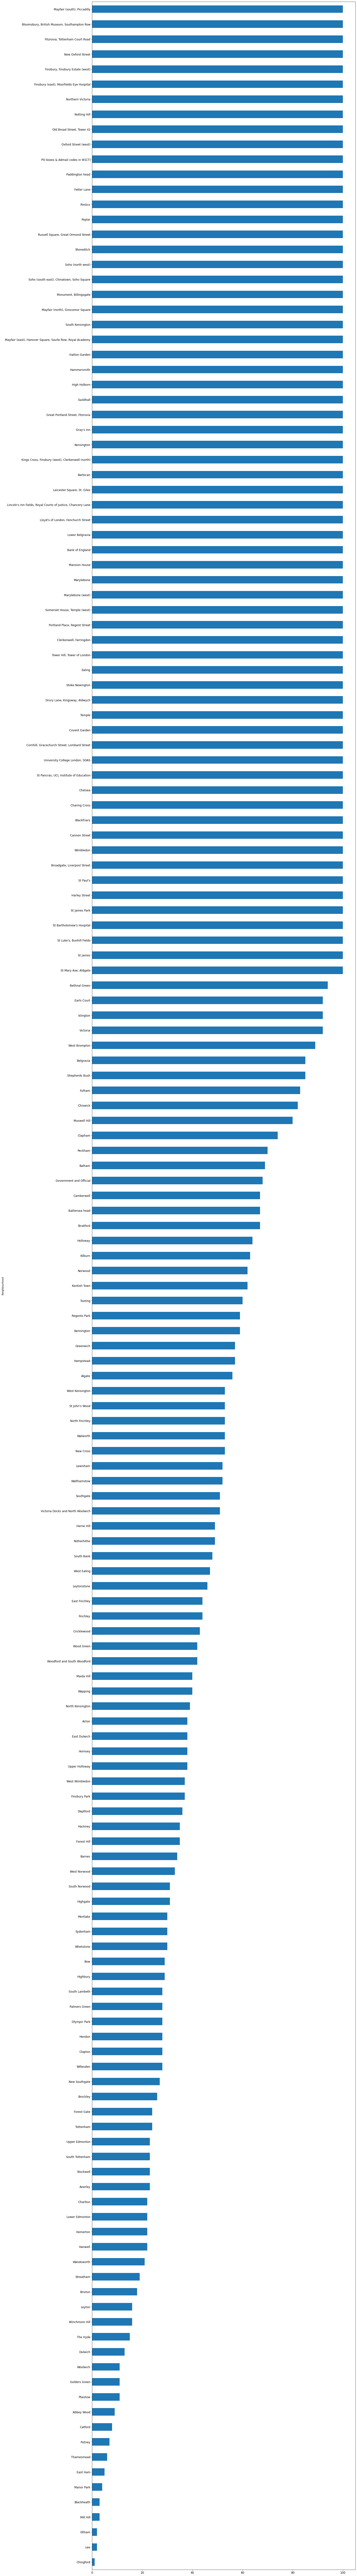

In [60]:
bar_data.plot.barh(fontsize = 12, figsize = (20,200))


More than 60 neighbourhoods have 95-100 venues in them:


<AxesSubplot:ylabel='Frequency'>

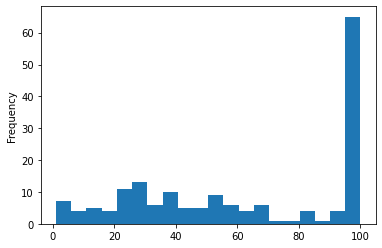

In [61]:
print('More than 60 neighbourhoods have 95-100 venues in them:')
    
bar_data.plot.hist(bins=20)

In [62]:
print('The most common venues in London are:')
London_venues['Venue Category'].value_counts().head(20).to_frame()

The most common venues in London are:


Venue Category
Coffee Shop                      665
Pub                              523
Café                             497
Hotel                            393
Italian Restaurant               365
Sandwich Place                   232
Gym / Fitness Center             223
Grocery Store                    218
Bakery                           213
Restaurant                       191
Cocktail Bar                     183
Clothing Store                   175
Pizza Place                      175
Indian Restaurant                173
French Restaurant                171
Park                             152
Bar                              136
Fast Food Restaurant             128
Bus Stop                         117
Burger Joint                     116

### Clustering Analysis <a name="Clust"></a>

In [63]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# insert neighborhood column back to dataframe in the first column
London_onehot.insert(0,'Neighbourhood', London_venues['Neighbourhood']) 

London_onehot.head()

Neighbourhood  Accessories Store  Adult Boutique  Advertising Agency  \
0        Algate                  0               0                   0   
1        Algate                  0               0                   0   
2        Algate                  0               0                   0   
3        Algate                  0               0                   0   
4        Algate                  0               0                   0   

   Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0                  0                   0                    0             0   
1                  0                   0                    0             0   
2                  0                   0                    0             0   
3                  0                   0                    0             0   
4                  0                   0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                   0                      0                    0   
1                   0                      0                    0   
2                   0                      0                    0   
3                   0                      0                    0   
4                   0                      0                    0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0                0          0           0           0       0   
1            0                0          0           0           0       1   
2            0                0          0           0           0       0   
3            0                0          0           0           0       0   
4            0                0          0           0           0       0   

   Bar  Baseball Field  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0    0               0      0                0         0            0   
1    0               0      0                0         0            0   
2    0               0      0                0         0            0   
3    0               0      0                0         0            0   
4    0               0      0                0         0            0   

   Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  Bike Trail  \
0           0             0                         0          0           0   
1           0             0                         0          0           0   
2           0             0                         0          0           0   
3           0             0                         0          0           0   
4           0             0                         0          0           0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0       0               0              0          0                 0   
1       0               0              0          0                 0   
2       0               0              0          0                 0   
3       0               0              0          0                 0   
4       0               0          

In [64]:
London_onehot.shape

(10758, 403)

In [65]:
London_grouped = London_onehot.groupby('Neighbourhood').mean().reset_index()

In [66]:
London_grouped.head()

Neighbourhood  Accessories Store  Adult Boutique  Advertising Agency  \
0    Abbey Wood                0.0             0.0                 0.0   
1         Acton                0.0             0.0                 0.0   
2        Algate                0.0             0.0                 0.0   
3       Anerley                0.0             0.0                 0.0   
4        Balham                0.0             0.0                 0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0                0.0                 0.0                  0.0           0.0   
1                0.0                 0.0                  0.0           0.0   
2                0.0                 0.0                  0.0           0.0   
3                0.0                 0.0                  0.0           0.0   
4                0.0                 0.0                  0.0           0.0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0                     0.0          0.0         0.0   
1     0.0               0.0                     0.0          0.0         0.0   
2     0.0               0.0                     0.0          0.0         0.0   
3     0.0               0.0                     0.0          0.0         0.0   
4     0.0               0.0                     0.0          0.0         0.0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0          0.000000   
1                  0.0                   0.0          0.000000   
2                  0.0                   0.0          0.017857   
3                  0.0                   0.0          0.000000   
4                  0.0                   0.0          0.000000   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                 0.0                    0.0                  0.0   
1                 0.0                    0.0                  0.0   
2                 0.0                    0.0                  0.0   
3                 0.0                    0.0                  0.0   
4                 0.0                    0.0                  0.0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery  \
0          0.0              0.0        0.0         0.0         0.0  0.000000   
1          0.0              0.0        0.0         0.0         0.0  0.026316   
2          0.0              0.0        0.0         0.0         0.0  0.035714   
3          0.0              0.0        0.0         0.0         0.0  0.000000   
4          0.0              0.0        0.0         0.0         0.0  0.043478   

        Bar  Baseball Field  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0  0.000000             0.0    0.0              0.0       0.0          0.0   
1  0.000000             0.0    0.0              0.0       0.0          0.0   
2  0.000000             0.0    0.0              0.0       0.0          0.0   
3  0.000000             0.0    0.0              0.0       0.0          0.0   
4  0.028986             0.0    0.0              0.0       0.0          0.0   

   Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  Bike Trail  \
0    0.000000      0.111111                       0.0        0.0         0.0   
1    0.000000      0.026316                       0.0        0.0         0.0   
2    0.000000      0.017857                       0.0        0.0         0.0   
3    0.000000      0.000000                       0.0        0.0         0.0   
4    0.014493      0.000000                       0.0        0.0         0.0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0     0.0             0.0            0.0   0.000000               0.0   
1     0.0             0.0            0.0   0.000000               0.0   
2     0.0             0.0            0.0   0.000000               0.0   
3     0.0             0.0            0.0   0.000000               

In [67]:
London_grouped.shape

(171, 403)

In [68]:
#London_grouped['index_col'] = London_grouped.index

In [69]:
London_grouped.head()
London_grouped.shape

(171, 403)

In [70]:
#First, let's write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
LDN_Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
LDN_Neighbourhoods_venues_sorted['Neighbourhood'] = London_grouped['Neighbourhood']

for ind in np.arange(London_grouped.shape[0]):
    LDN_Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

LDN_Neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0    Abbey Wood            Campground           Supermarket   
1         Acton                   Pub                  Park   
2        Algate                   Pub                 Hotel   
3       Anerley  Fast Food Restaurant           Supermarket   
4        Balham           Coffee Shop                   Pub   

  3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0          Betting Shop       Convenience Store         Grocery Store   
1           Supermarket    Gym / Fitness Center  Fast Food Restaurant   
2     Indian Restaurant             Coffee Shop         Grocery Store   
3           Pizza Place  Furniture / Home Store                  Café   
4                  Café       Indian Restaurant           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Train Station              Platform           Coffee Shop   
1         Train Station           Coffee Shop                 Hotel   
2        Sandwich Place          Burger Joint                Bakery   
3                   Pub         Shopping Mall    Chinese Restaurant   
4                Bakery              Platform     Fish & Chips Shop   

  9th Most Common Venue 10th Most Common Venue  
0      Stationery Store  Performing Arts Venue  
1     Convenience Store            Pizza Place  
2  Gym / Fitness Center         Ice Cream Shop  
3                  Park              Pawn Shop  
4                   Bar            Supermarket

In [72]:
Sum_of_squared_distances = []

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

for kclusters in range(1,15):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    

kmeans.labels_ 

array([ 6,  7,  1,  4, 13,  5,  5,  7, 13,  1, 13,  5, 11, 10,  0,  0,  5,
        4, 13,  5,  0, 10,  0, 13,  8, 13, 13,  0,  5,  5, 10,  0, 13, 10,
       13, 13,  1,  4,  7,  0, 12,  5, 13,  5,  4,  7,  5,  0,  7, 13,  5,
        7,  1,  5,  7,  5, 13,  7, 13,  4,  5,  5,  0, 13,  1,  4,  7, 13,
        7, 13,  7,  7, 13, 13, 13,  7,  3, 10, 13,  1, 13,  1,  5,  1, 13,
       13,  9,  5, 10,  1, 10, 10, 10,  2,  5, 13, 13,  4, 10,  0, 13, 13,
        1, 13,  5,  5, 13, 10,  5,  1, 13, 13,  1,  4,  5, 10,  0, 13, 13,
        1, 10,  5, 10, 10, 10,  7,  1,  7,  6,  7, 13,  5, 10,  1, 13,  5,
        5,  1,  5, 13,  7, 13,  7, 13,  5,  4,  0, 13,  7,  1,  5,  0,  0,
        1,  1, 13,  4,  7, 13,  5, 13,  1, 13,  0, 13,  4, 13,  5,  4, 13,
        7])

We will use number of clusters k = 5


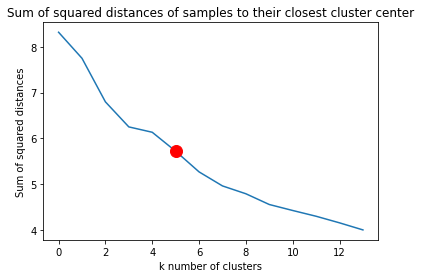

In [73]:
import matplotlib.pyplot as plt
plt.plot(Sum_of_squared_distances)
plt.xlabel('k number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Sum of squared distances of samples to their closest cluster center')

plt.plot( [5.0],[Sum_of_squared_distances[5]], marker='o', markersize=12, color = 'red')
print('We will use number of clusters k = 5')

In [74]:
kclusters = 5

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 4, 2, 2, 4, 4, 2, 2, 0, 2, 4, 1, 4, 2, 2, 4, 2, 2, 4, 2, 4,
       2, 4, 3, 4, 2, 2, 4, 4, 4, 2, 2, 4, 2, 4, 0, 2, 2, 2, 1, 4, 2, 4,
       2, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 4, 0, 4, 2, 2, 4, 4, 2, 2, 4, 2,
       2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 1, 4, 2, 4, 2, 4, 4, 4, 4, 2, 0, 4,
       4, 0, 4, 4, 4, 1, 4, 2, 2, 2, 4, 2, 4, 2, 4, 4, 4, 4, 0, 4, 4, 0,
       2, 4, 4, 2, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 0,
       0, 4, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 4, 4, 2, 2, 2])

In [75]:
#LDN_Neighbourhoods_venues_sorted.drop('Cluster Labels',axis=1, inplace = True)

In [76]:
# add clustering labels  DataFrame.insert(loc, column, value, allow_duplicates=False)
LDN_Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [77]:
LDN_Neighbourhoods_venues_sorted.head()

Cluster Labels Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               2    Abbey Wood            Campground           Supermarket   
1               2         Acton                   Pub                  Park   
2               4        Algate                   Pub                 Hotel   
3               2       Anerley  Fast Food Restaurant           Supermarket   
4               2        Balham           Coffee Shop                   Pub   

  3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0          Betting Shop       Convenience Store         Grocery Store   
1           Supermarket    Gym / Fitness Center  Fast Food Restaurant   
2     Indian Restaurant             Coffee Shop         Grocery Store   
3           Pizza Place  Furniture / Home Store                  Café   
4                  Café       Indian Restaurant           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Train Station              Platform           Coffee Shop   
1         Train Station           Coffee Shop                 Hotel   
2        Sandwich Place          Burger Joint                Bakery   
3                   Pub         Shopping Mall    Chinese Restaurant   
4                Bakery              Platform     Fish & Chips Shop   

  9th Most Common Venue 10th Most Common Venue  
0      Stationery Store  Performing Arts Venue  
1     Convenience Store            Pizza Place  
2  Gym / Fitness Center         Ice Cream Shop  
3                  Park              Pawn Shop  
4                   Bar            Supermarket

In [78]:
London_merged = London_df.join(LDN_Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [79]:
London_merged.head()

Postcode    City  Neighbourhood  \
0       E1  LONDON         Algate   
1      E1W  LONDON        Wapping   
2       E2  LONDON  Bethnal Green   
3       E3  LONDON            Bow   
4       E4  LONDON      Chingford   

                                          Borough  latitude  longitude  \
0          Tower Hamlets, Hackney, City of London  51.51766   -0.05841   
1                                   Tower Hamlets  51.50775   -0.05739   
2                          Tower Hamlets, Hackney  51.52939   -0.06080   
3                           Tower Hamlets, Newham  51.52789   -0.02482   
4  Waltham Forest, Enfield, Epping Forest (Essex)  51.62196   -0.00339   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               4                   Pub                 Hotel   
1               2                   Pub           Coffee Shop   
2               2           Coffee Shop                  Café   
3               2         Grocery Store              Bus Stop   
4               3   American Restaurant        Adult Boutique   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant           Coffee Shop         Grocery Store   
1         Grocery Store  Fast Food Restaurant  Gym / Fitness Center   
2                   Pub          Cocktail Bar         Grocery Store   
3                 Hotel                   Pub                  Café   
4  Pakistani Restaurant             Pet Store   Peruvian Restaurant   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0        Sandwich Place          Burger Joint                 Bakery   
1    Italian Restaurant     Convenience Store                   Park   
2                  Park                 Hotel     Turkish Restaurant   
3             Locksmith           Coffee Shop                    Gym   
4    Persian Restaurant          Perfume Shop  Performing Arts Venue   

  9th Most Common Venue 10th Most Common Venue  
0  Gym / Fitness Center         Ice Cream Shop  
1   Fried Chicken Joint     Chinese Restaurant  
2  Fast Food Restaurant                    Gym  
3         Metro Station        Nature Preserve  
4      Pedestrian Plaza              Pawn Shop

In [80]:
Neighbourhoods_per_cluster = London_merged['Cluster Labels'].value_counts().sort_index().to_frame()
Neighbourhoods_per_cluster.columns = ['No. of Neighbourhoods per Neighbourhood cluster']
Neighbourhoods_per_cluster

No. of Neighbourhoods per Neighbourhood cluster
0                                               10
1                                                4
2                                               81
3                                                1
4                                               75

<AxesSubplot:>

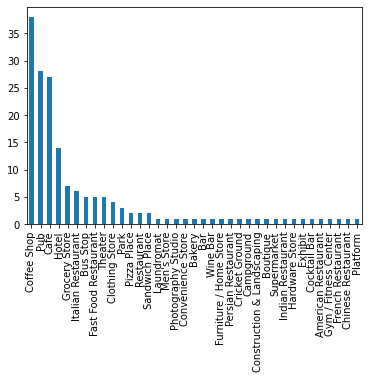

In [81]:
London_merged['1st Most Common Venue'].value_counts().plot.bar()

In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['latitude'], London_merged['longitude']
                                  , London_merged['Neighbourhood'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Recommender system
This is a simple content-based recommender system.

Each neighbourhood is defined by the types and number of venues it has. So each neighbourhood has a unique set of characteristics (much like a movie might belong to particular genres). 

A user will rate a few neighbourhoods, and these ratings will be used to create a user profile of his preferences.

Using the preferences in the user profile along with the neighbourhood characteristics, we can recommned neighbourhoods that are similar. In other words the recommender system provides the neighbourhoods whose characteristics (venues) most closely  match the user preferences.

In [83]:
#sample user input
userInput = [
            {'Neighbourhood':'Hammersmith', 'rating':3},
            {'Neighbourhood':'Clapham', 'rating':9},
            {'Neighbourhood':'Earls Court', 'rating':9},
            {'Neighbourhood':'Brixton', 'rating':1},
            {'Neighbourhood':'Marylebone', 'rating':10}]

neighbourhood_ratings = pd.DataFrame(userInput)

In [84]:
neighbourhood_ratings

Neighbourhood  rating
0   Hammersmith       3
1       Clapham       9
2   Earls Court       9
3       Brixton       1
4    Marylebone      10

In [85]:
London_grouped.head()

Neighbourhood  Accessories Store  Adult Boutique  Advertising Agency  \
0    Abbey Wood                0.0             0.0                 0.0   
1         Acton                0.0             0.0                 0.0   
2        Algate                0.0             0.0                 0.0   
3       Anerley                0.0             0.0                 0.0   
4        Balham                0.0             0.0                 0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0                0.0                 0.0                  0.0           0.0   
1                0.0                 0.0                  0.0           0.0   
2                0.0                 0.0                  0.0           0.0   
3                0.0                 0.0                  0.0           0.0   
4                0.0                 0.0                  0.0           0.0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0                     0.0          0.0         0.0   
1     0.0               0.0                     0.0          0.0         0.0   
2     0.0               0.0                     0.0          0.0         0.0   
3     0.0               0.0                     0.0          0.0         0.0   
4     0.0               0.0                     0.0          0.0         0.0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0          0.000000   
1                  0.0                   0.0          0.000000   
2                  0.0                   0.0          0.017857   
3                  0.0                   0.0          0.000000   
4                  0.0                   0.0          0.000000   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                 0.0                    0.0                  0.0   
1                 0.0                    0.0                  0.0   
2                 0.0                    0.0                  0.0   
3                 0.0                    0.0                  0.0   
4                 0.0                    0.0                  0.0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery  \
0          0.0              0.0        0.0         0.0         0.0  0.000000   
1          0.0              0.0        0.0         0.0         0.0  0.026316   
2          0.0              0.0        0.0         0.0         0.0  0.035714   
3          0.0              0.0        0.0         0.0         0.0  0.000000   
4          0.0              0.0        0.0         0.0         0.0  0.043478   

        Bar  Baseball Field  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0  0.000000             0.0    0.0              0.0       0.0          0.0   
1  0.000000             0.0    0.0              0.0       0.0          0.0   
2  0.000000             0.0    0.0              0.0       0.0          0.0   
3  0.000000             0.0    0.0              0.0       0.0          0.0   
4  0.028986             0.0    0.0              0.0       0.0          0.0   

   Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  Bike Trail  \
0    0.000000      0.111111                       0.0        0.0         0.0   
1    0.000000      0.026316                       0.0        0.0         0.0   
2    0.000000      0.017857                       0.0        0.0         0.0   
3    0.000000      0.000000                       0.0        0.0         0.0   
4    0.014493      0.000000                       0.0        0.0         0.0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0     0.0             0.0            0.0   0.000000               0.0   
1     0.0             0.0            0.0   0.000000               0.0   
2     0.0             0.0            0.0   0.000000               0.0   
3     0.0             0.0            0.0   0.000000               

In [86]:
input_neighbourhood = neighbourhood_ratings.merge(London_grouped)

In [87]:
input_neighbourhood

Neighbourhood  rating  Accessories Store  Adult Boutique  \
0   Hammersmith       3                0.0             0.0   
1       Clapham       9                0.0             0.0   
2   Earls Court       9                0.0             0.0   
3       Brixton       1                0.0             0.0   
4    Marylebone      10                0.0             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  \
0                 0.0                0.0                 0.0   
1                 0.0                0.0                 0.0   
2                 0.0                0.0                 0.0   
3                 0.0                0.0                 0.0   
4                 0.0                0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                    0.00         0.00         0.0                  0.0   
1                    0.00         0.00         0.0                  0.0   
2                    0.00         0.00         0.0                  0.0   
3                    0.00         0.00         0.0                  0.0   
4                    0.01         0.01         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0          0.010000                 0.0   
1                   0.0          0.013514                 0.0   
2                   0.0          0.000000                 0.0   
3                   0.0          0.000000                 0.0   
4                   0.0          0.000000                 0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Automotive Shop  \
0                    0.0                 0.00     0.000000              0.0   
1                    0.0                 0.00     0.000000              0.0   
2                    0.0                 0.00     0.000000              0.0   
3                    0.0                 0.00     0.055556              0.0   
4                    0.0                 0.01     0.000000              0.0   

   BBQ Joint  Baby Store  Bagel Shop    Bakery       Bar  Baseball Field  \
0   0.000000         0.0         0.0  0.020000  0.010000             0.0   
1   0.013514         0.0         0.0  0.013514  0.027027             0.0   
2   0.010870         0.0         0.0  0.000000  0.021739             0.0   
3   0.000000         0.0         0.0  0.000000  0.000000             0.0   
4   0.000000         0.0         0.0  0.020000  0.000000             0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0    0.0          0.00000      0.01          0.0         0.0           0.0   
1    0.0          0.00000      0.00          0.0         0.0           0.0   
2    0.0          0.01087      0.00          0.0         0.0           0.0   
3    0.0          0.00000      0.00          0.0         0.0           0.0   
4    0.0          0.00000      0.00          0.0         0.0           0.0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail    Bistro  Boarding House  \
0                       0.0        0.0         0.0  0.000000            0.01   
1                       0.0        0.0         0.0  0.013514            0.00   
2                       0.0        0.0         0.0  0.000000            0.00   
3                       0.0        0.0         0.0  0.000000            0.00   
4                       0.0        0.0         0.0  0.000000            0.00   

   Boat or Ferry  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0            0.0   0.000000               0.0    

In [88]:
input_neighbourhood.iloc[:, 2:].transpose()

0         1         2         3  \
Accessories Store                         0.00  0.000000  0.000000  0.000000   
Adult Boutique                            0.00  0.000000  0.000000  0.000000   
Advertising Agency                        0.00  0.000000  0.000000  0.000000   
Afghan Restaurant                         0.00  0.000000  0.000000  0.000000   
African Restaurant                        0.00  0.000000  0.000000  0.000000   
American Restaurant                       0.00  0.000000  0.000000  0.000000   
Antique Shop                              0.00  0.000000  0.000000  0.000000   
Arcade                                    0.00  0.000000  0.000000  0.000000   
Arepa Restaurant                          0.00  0.000000  0.000000  0.000000   
Argentinian Restaurant                    0.00  0.000000  0.000000  0.000000   
Art Gallery                               0.00  0.000000  0.000000  0.000000   
Art Museum                                0.00  0.000000  0.000000  0.000000   
Arts & Crafts Store                       0.00  0.000000  0.000000  0.000000   
Arts & Entertainment                      0.00  0.000000  0.000000  0.000000   
Asian Restaurant                          0.01  0.013514  0.000000  0.000000   
Athletics & Sports                        0.00  0.000000  0.000000  0.000000   
Australian Restaurant                     0.00  0.000000  0.000000  0.000000   
Austrian Restaurant                       0.00  0.000000  0.000000  0.000000   
Auto Garage                               0.00  0.000000  0.000000  0.055556   
Automotive Shop                           0.00  0.000000  0.000000  0.000000   
BBQ Joint                                 0.00  0.013514  0.010870  0.000000   
Baby Store                                0.00  0.000000  0.000000  0.000000   
Bagel Shop                                0.00  0.000000  0.000000  0.000000   
Bakery                                    0.02  0.013514  0.000000  0.000000   
Bar                                       0.01  0.027027  0.021739  0.000000   
Baseball Field                            0.00  0.000000  0.000000  0.000000   
Beach                                     0.00  0.000000  0.000000  0.000000   
Bed & Breakfast                           0.00  0.000000  0.010870  0.000000   
Beer Bar                                  0.01  0.000000  0.000000  0.000000   
Beer Garden                               0.00  0.000000  0.000000  0.000000   
Beer Store                                0.00  0.000000  0.000000  0.000000   
Betting Shop                              0.00  0.000000  0.000000  0.000000   
Bike Rental / Bike Share                  0.00  0.000000  0.000000  0.000000   
Bike Shop                                 0.00  0.000000  0.000000  0.000000   
Bike Trail                                0.00  0.000000  0.000000  0.000000   
Bistro                                    0.00  0.013514  0.000000  0.000000   
Boarding House                            0.01  0.000000  0.000000  0.000000   
Boat or Ferry                             0.00  0.000000  0.000000  0.000000   
Bookstore                                 0.00  0.013514  0.000000  0.000000   
Botanical Garden                          0.00  0.000000  0.000000  0.000000   
Boutique                                  0.00  0.000000  0.000000  0.000000   
Bowling Alley                             0.00  0.000000  0.000000  0.000000   
Bowling Green                             0.00  0.000000  0.000000  0.000000   
Boxing Gym                                0.00  0.000000  0.000000  0.000000   
Brasserie                                 0.00  0.000000  0.000000  0.000000   
Brazilian Restaurant                      0.00  0.013514  0.000000  0.000000   
Breakfast Spot                            0.01  0.013514  0.000000  0.000000   
Brewery                                   0.00  0.000000  0.000000  0.000000   
Bridal Shop                               0.00  0.000000  0.000000  0.000000   
Bridge                                    0.0

In [89]:
#Dot produt to get weights
userProfile = input_neighbourhood.iloc[:, 2:].transpose().dot(input_neighbourhood['rating'])
#The user profile
#userProfile.sort_values(ascending=False)
userProfile.sort_values

<bound method Series.sort_values of Accessories Store                           0.000000
Adult Boutique                              0.000000
Advertising Agency                          0.000000
Afghan Restaurant                           0.000000
African Restaurant                          0.000000
American Restaurant                         0.000000
Antique Shop                                0.000000
Arcade                                      0.000000
Arepa Restaurant                            0.000000
Argentinian Restaurant                      0.100000
Art Gallery                                 0.100000
Art Museum                                  0.000000
Arts & Crafts Store                         0.000000
Arts & Entertainment                        0.000000
Asian Restaurant                            0.151622
Athletics & Sports                          0.000000
Australian Restaurant                       0.000000
Austrian Restaurant                         0.100000
Auto Garag

In [90]:
userProfile.sort_values(ascending=False).to_frame().head(10)

0
Hotel               3.399130
Pub                 1.808446
Café                1.317239
Coffee Shop         1.070655
Burger Joint        1.044313
Sandwich Place      0.821069
Italian Restaurant  0.796722
French Restaurant   0.795652
Cocktail Bar        0.790517
Indian Restaurant   0.730655

In [91]:
normalised_userProfile = userProfile/userProfile.sum()

In [92]:
normalised_userProfile.shape
London_grouped.iloc[:,1:].shape

(171, 402)

In [93]:
#Multiply the characteristics by the weights and then take the weighted average
recommendationTable_df = (London_grouped.iloc[:,1:]*normalised_userProfile).sum(axis=1)
recommendationTable_df.head()

0    0.008108
1    0.020259
2    0.022862
3    0.019777
4    0.020118
dtype: float64

In [94]:
#London_grouped.drop('rating', axis = 1, inplace = True)
#London_grouped.head()

In [95]:
#London_grouped.drop('Relative Rating', axis = 1, inplace = True)
London_grouped.insert(1,'Relative Rating', recommendationTable_df )

In [96]:
Ranking = London_grouped['Relative Rating'].rank(ascending=False)

In [97]:
#London_grouped.drop('Ranking', axis = 1, inplace = True)
London_grouped.insert(2,'Ranking', Ranking )

In [98]:
#London_grouped.drop('Cluster Labels', axis = 1, inplace = True)
London_grouped.insert(3,'Cluster Labels', kmeans.labels_)

In [99]:
London_grouped.sort_values(by='Relative Rating',ascending= False)

Neighbourhood  Relative Rating  \
36                                         Earls Court         0.047428   
161                                    West Kensington         0.033672   
109                                    Paddington head         0.030794   
153                                           Victoria         0.029724   
125                                         South Bank         0.028189   
112                                            Pimlico         0.026085   
14                                                 Bow         0.025961   
81   Lincoln's Inn Fields, Royal Courts of Justice,...         0.024958   
9                                            Belgravia         0.024469   
75   Kings Cross, Finsbury (west), Clerkenwell (north)         0.024393   
149                        Tower Hill, Tower of London         0.023976   
39                                            East Ham         0.023941   
83                                     Lower Belgravia         0.023663   
154                  Victoria Docks and North Woolwich         0.023494   
119                Russell Square, Great Ormond Street         0.023378   
102                                  Northern Victoria         0.023151   
144                                             Temple         0.022910   
2                                               Algate         0.022862   
133                                      St James Park         0.022765   
89                                   Marylebone (west)         0.022758   
51                             Government and Official         0.022542   
137             St Pancras, UCL Institute of Education         0.022370   
57                                         Hammersmith         0.021642   
48                                         Forest Hill         0.021531   
41                                         Fetter Lane         0.021292   
152                                     Upper Holloway         0.020959   
28                             Clerkenwell, Farringdon         0.020850   
52                                          Gray's Inn         0.020506   
45                    Finsbury, Finsbury Estate (west)         0.020445   
82                 Lloyd's of London, Fenchurch Street         0.020335   
1                                                Acton         0.020259   
67                                            Holloway         0.020231   
73                                        Kentish Town         0.020179   
71                                          Kennington         0.020120   
4                                               Balham         0.020118   
10                                       Bethnal Green         0.020111   
44                                       Finsbury Park         0.020091   
131                          St Bartholomew's Hospital         0.020028   
66                                            Highgate         0.019958   
49                                              Fulham         0.019938   
3                                              Anerley         0.019777   
164                                          Whetstone         0.019120   
68                                            Homerton         0.019061   
141                                          Stratford         0.018863   
121                                         Shoreditch         0.018772   
37                                        East Dulwich         0.018715   
80                                         Leytonstone         0.018705   
160                                        West Ealing         0.018638   
61                                       Hatton Garden         0.018588   
157                                         Wandsworth         0.018550   
65                                            Highbury         0.018476   
88                                          Marylebone         0.018463   
140                                    Stoke Newington         0.0

In [100]:
#London_grouped.drop(['Relative Rating','Cluster Labels','Ranking'], axis = 1, inplace = True)

In [101]:
LDN_Neighbourhoods_venues_sorted.insert(1,'Relative Rating', recommendationTable_df )
Ranking = LDN_Neighbourhoods_venues_sorted['Relative Rating'].rank(ascending=False)
LDN_Neighbourhoods_venues_sorted.insert(2,'Ranking', Ranking )
LDN_Neighbourhoods_venues_sorted.sort_values(by='Relative Rating',ascending= False)

Cluster Labels  Relative Rating  Ranking  \
36                0         0.047428      1.0   
161               0         0.033672      2.0   
109               0         0.030794      3.0   
153               0         0.029724      4.0   
125               2         0.028189      5.0   
112               4         0.026085      6.0   
14                2         0.025961      7.0   
81                4         0.024958      8.0   
9                 0         0.024469      9.0   
75                2         0.024393     10.0   
149               4         0.023976     11.0   
39                2         0.023941     12.0   
83                4         0.023663     13.0   
154               0         0.023494     14.0   
119               4         0.023378     15.0   
102               4         0.023151     16.0   
144               4         0.022910     17.0   
2                 4         0.022862     18.0   
133               4         0.022765     19.0   
89                0         0.022758     20.0   
51                2         0.022542     21.0   
137               4         0.022370     22.0   
57                4         0.021642     23.0   
48                2         0.021531     24.0   
41                4         0.021292     25.0   
152               2         0.020959     26.0   
28                4         0.020850     27.0   
52                4         0.020506     28.0   
45                2         0.020445     29.0   
82                4         0.020335     30.0   
1                 2         0.020259     31.0   
67                2         0.020231     32.0   
73                2         0.020179     33.0   
71                2         0.020120     34.0   
4                 2         0.020118     35.0   
10                2         0.020111     36.0   
44                2         0.020091     37.0   
131               4         0.020028     38.0   
66                2         0.019958     39.0   
49                2         0.019938     40.0   
3                 2         0.019777     41.0   
164               2         0.019120     42.0   
68                2         0.019061     43.0   
141               2         0.018863     44.0   
121               4         0.018772     45.0   
37                2         0.018715     46.0   
80                2         0.018705     47.0   
160               2         0.018638     48.0   
61                4         0.018588     49.0   
157               2         0.018550     50.0   
65                2         0.018476     51.0   
88                4         0.018463     52.0   
140               2         0.018448     53.0   
126               4         0.018368     54.0   
117               4         0.018241     55.0   
70                4         0.018230     56.0   
64                4         0.018207     57.0   
18                2         0.018149     58.0   
146               2         0.018081     59.0   
26                2         0.017966     60.0   
43                4         0.017946     61.0   
7                 2         0.017888     62.0   
58                2         0.017814     63.0   
47                2         0.017666     64.0   
53                4         0.017583     65.0   
94                4         0.017502     66.0   
69                2         0.017502     67.0   
54                2         0.017485     68.0   
136               4         0.017274     69.0   
23                4         0.017259     70.0   
97                2         0.017138     71.0   
113               2         0.017123     72.0   
169               2         0.016994     73.0   
8                 2         0.016972     74.0   
91                4         0.016969     75.0   
170               2         0.016911     76.0   
38                2         0.016825     77.0   
29                4         0.016772     78.0   
13                4         0.016681     79.0   
105               4         0.016659     80.0   
92                4         0.016585